In [28]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch

import numpy as np
import matplotlib.pyplot as plt

from datasets import ring_dataset, randomized_ring_dataset, energy_randomized_ring_dataset
from models import DGBaNR, big_DGBaNR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load dataset:

In [29]:
data_gen = energy_randomized_ring_dataset(N=32)
features, imgs = data_gen.generate_dataset(data_size=640000, seed=42, device='cpu', test_return=True)

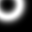

In [30]:
gaussian_ring, center, mean, sig = data_gen.gaussian_ring(1)
gaussian_ring, center, mean, sig = gaussian_ring[0], center[0], mean[0], sig[0]

features = torch.Tensor([[center[0], center[1], mean, sig, gaussian_ring.mean() * 32 * 32]])

Image.fromarray((gaussian_ring.reshape((32, 32)) * 255).astype(np.uint8))

Load generator:

In [34]:
generator = big_DGBaNR(data_gen.n_features, 32, 'sigmoid')
generator.load_state_dict(torch.load('../save_model/big_DGBaNR_sigmoid_energy_random_640000_64_Adam_mse_loss_1.pt', map_location=torch.device('cpu')))
generator.eval()

big_DGBaNR(
  (linear1): LinearReparameterization()
  (linear2): LinearReparameterization()
  (conv1): ConvTranspose2dReparameterization()
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2dReparameterization()
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2dReparameterization()
)

In [42]:
feature = [15, 15, 9.4, 3.6]
features = torch.Tensor(data_gen.scaler.transform(np.array([feature for i in range(1000)])))

In [43]:
with torch.no_grad():
    pred_rings = generator(features)[0].numpy().squeeze()
pred_rings = pred_rings.sum(axis=0)
print(pred_rings.max())

687.3553


/home/J000000000007/envs/DGBaN/lib64/python3.6/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [44]:
pred_prob = pred_rings * 255 / pred_rings.max()
prob = data_gen.gaussian_from_features(*feature) * 255

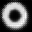

In [45]:
Image.fromarray(pred_prob.astype(np.uint8))

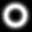

In [46]:
Image.fromarray(prob.astype(np.uint8))

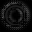

In [47]:
Image.fromarray(np.abs(prob - pred_prob).astype(np.uint8))

In [48]:
# relative error
print(np.abs(prob - pred_prob).mean() / prob.mean())

0.18116398695422897


In [41]:
img = generator(torch.Tensor(data_gen.scaler.transform(np.array([[13, 26.0000, 11.4000, 5.6000]]))))[0].detach().numpy().squeeze()
img = img * 255 / img.max()